In [ ]:
!mv  '/content/drive/My Drive/slot_attention/tensorflow_datasets' '/root'

In [ ]:
%cd /content/drive/My Drive
import tensorflow as tf
import tensorflow_datasets as tfds
from absl import logging
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# When executing this notebook out of a subfolder, use the command below to
# change to the project's root folder (required for imports):
# %cd ..

import slot_attention.data as data_utils
import slot_attention.model as model_utils

/content/drive/My Drive


In [ ]:
ds = tfds.load("Vrep32k", split='test', shuffle_files=False)
ds

<PrefetchDataset shapes: {file_name: (), image: (None, None, 3)}, types: {file_name: tf.string, image: tf.uint8}>

In [ ]:
seed = 0
batch_size = 1
num_slots = 7
num_iterations = 3
resolution = (128,128)
ckpt_path = "/content/drive/MyDrive/slot_attention/finetune_32k/"  # Path to model checkpoint.

In [ ]:
def preprocess_clevr(features, resolution, apply_crop=False,
                     get_properties=True, max_n_objects=10):
  """Preprocess CLEVR."""
  image = tf.cast(features["image"], dtype=tf.float32)
  image = ((image / 255.0) - 0.5) * 2.0  # Rescale to [-1, 1].
  crop = ((150,2000), (100,2000))  # Get center crop.
  image = image[crop[0][0]:crop[0][1], crop[1][0]:crop[1][1], :]

  image = tf.image.resize(
      image, resolution, method=tf.image.ResizeMethod.BILINEAR)
  image = tf.clip_by_value(image, -1., 1.)

 
  features = {"image": image,
              "file_name": features["file_name"]}

  return features


def build_clevr(split, resolution=(128, 128), shuffle=False, max_n_objects=10,
                num_eval_examples=512, get_properties=True, apply_crop=False):
  """Build CLEVR dataset."""
  
  ds = tfds.load("Vrep32k", split='test', shuffle_files=False)
  

  def _preprocess_fn(x, resolution, max_n_objects=max_n_objects):
    return preprocess_clevr(
        x, resolution, apply_crop=apply_crop, get_properties=get_properties,
        max_n_objects=max_n_objects)
  ds = ds.map(lambda x: _preprocess_fn(x, resolution))
  return ds


def build_clevr_iterator(batch_size, split, **kwargs):
  ds = build_clevr(split=split, **kwargs)
  ds = ds.repeat(-1)
  ds = ds.batch(batch_size, drop_remainder=True)
  return iter(ds)

In [ ]:
def load_model(checkpoint_dir, num_slots=7, num_iters=3, batch_size=1):
  resolution = (128,128)
  model = model_utils.build_model(
      resolution, batch_size, num_slots, num_iters,
      model_type="object_discovery")


  ckpt = tf.train.Checkpoint(network=model)
  ckpt_manager = tf.train.CheckpointManager(
      ckpt, directory=checkpoint_dir, max_to_keep=5)

  if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Restored from %s", ckpt_manager.latest_checkpoint)

  return model

In [ ]:
import collections
data_iterator = build_clevr_iterator(
    1, split="test", resolution=(128,128), shuffle=False, apply_crop=True)

model = load_model(ckpt_path, num_slots=7, num_iters=3,
                   batch_size=1)

Restored from %s /content/drive/MyDrive/slot_attention/finetune_32k/ckpt-57


In [ ]:
def renormalize(x):
  """Renormalize from [-1, 1] to [0, 1]."""
  return x / 2. + 0.5

def get_prediction(model, batch, idx=0):
  recon_combined, recons, masks, slots = model(batch["image"])
  image = renormalize(batch["image"])[idx]
  recon_combined = renormalize(recon_combined)[idx]
  recons = renormalize(recons)[idx]
  masks = masks[idx]
  return image, recon_combined, recons, masks, slots

tf.Tensor([b'287_full_image.jpg'], shape=(1,), dtype=string)


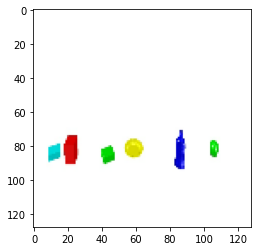

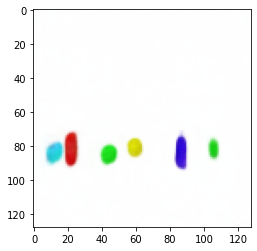

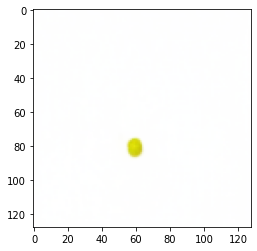

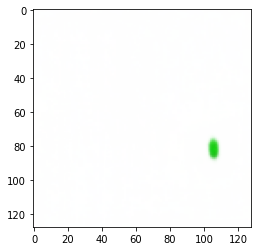

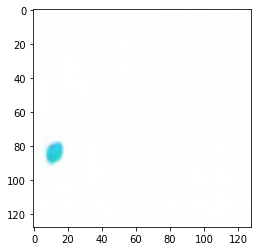

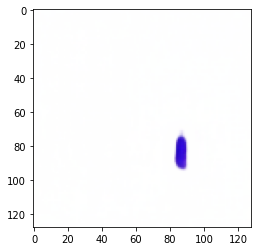

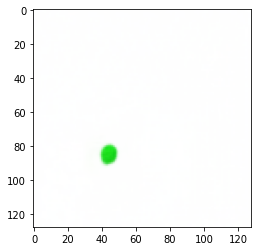

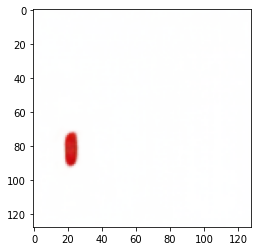

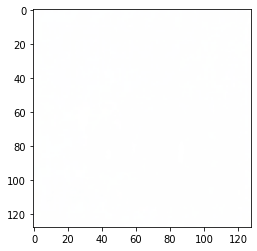

In [ ]:
batch = next(data_iterator)
print(batch["file_name"])
image, recon_combined, recons, masks, slots = get_prediction(model, batch)
num_slots = len(masks)
# fig, ax = plt.subplots(1, num_slots + 2, figsize=(15, 2))
plt.imshow(image)
plt.show()
plt.imshow(recon_combined)
plt.show()

# ax[0].imshow(image)
# ax[0].set_title('Image')
# ax[1].imshow(recon_combined)
# ax[1].set_title('Recon.')
for i in range(num_slots):
  plt.imshow(recons[i] * masks[i] + (1 - masks[i]))
  plt.show()
for i in range(len(ax)):
  ax[i].grid(False)
  ax[i].axis('off')